In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *
from encoding_information.plot_utils import *

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-01-09 09:45:06.315110: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 09:45:06.955759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-09 09:45:06.955832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-09 09:45:06.955840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Opening BSCCM
Opened BSCCM


In [2]:
# load images, extract patches, and compute cov mats
edge_crop = 32
num_images = 20000
num_patches = 20000
channel = 'LED119'

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]


In [3]:
patch_sizes = [1, 2, 3, 5, 10, 20, 35, 50]
num_samples = 8
sample_size = 80
eigenvalue_floor = 1e-1


# patch_sizes = [1, 5, 10]
# num_samples = 8
# sample_size = 40


# load train and test patches corresponding to the biggest patch size
patches = extract_patches(images, patch_sizes[-1], num_patches=num_patches, seed=0, verbose=True)
test_patches = extract_patches(test_images, patch_sizes[-1], num_patches=num_test_images, seed=0, verbose=True)


test_set_NLL_gp = {}
test_set_NLL_pixel_cnn = {}
mi_estimates_gp = {}
mi_estimates_pixel_cnn = {}
samples = {}
for patch_size in tqdm(patch_sizes, desc='patch sizes'):
    # take a random sub crop from the patchs
    subpatches = extract_patches(patches, patch_size, num_patches=num_patches, seed=0, verbose=False)
    test_subpatches = extract_patches(test_patches, patch_size, num_patches=num_test_images, seed=0, verbose=False)

    mi_estimates_gp[patch_size], stationary_gp = estimate_mutual_information(
        subpatches, eigenvalue_floor=eigenvalue_floor, use_iterative_optimization=True, return_entropy_model=True,
        verbose=True)
    test_set_NLL_gp[patch_size] = stationary_gp.compute_negative_log_likelihood(test_subpatches)

    mi_estimates_pixel_cnn[patch_size], pixel_cnn = estimate_mutual_information(
        subpatches, entropy_model='pixelcnn', return_entropy_model=True, verbose=True)
    test_set_NLL_pixel_cnn[patch_size] = pixel_cnn.compute_negative_log_likelihood(test_subpatches)

    samples[patch_size] = {}
    print('generating samples GP')
    samples[patch_size]['GP'] = stationary_gp.generate_samples(num_samples=num_samples, sample_shape=sample_size, seed=None)
    print('generating samples PixelCNN')
    samples[patch_size]['PixelCNN'] = pixel_cnn.generate_samples(num_samples=num_samples, sample_shape=sample_size, seed=None)

print('GP MI estimates', mi_estimates_gp)
print('PixelCNN MI estimates', mi_estimates_pixel_cnn)

patch sizes:   0%|                                        | 0/8 [00:00<?, ?it/s]2024-01-09 09:53:55.835985: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 7.19



Epoch 1: 100%|████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 1: validation NLL: 7.19



Epoch 2: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 126.41it/s]


Epoch 2: validation NLL: 7.19



Epoch 3: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 403.18it/s]


Epoch 3: validation NLL: 7.19



Epoch 4: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 189.60it/s]


Epoch 4: validation NLL: 7.19



Epoch 5: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 211.34it/s]


Epoch 5: validation NLL: 7.19



Epoch 6: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 198.05it/s]


Epoch 6: validation NLL: 7.19



Epoch 7: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 181.28it/s]


Epoch 7: validation NLL: 7.19



Epoch 8: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 438.55it/s]


Epoch 8: validation NLL: 7.19



Epoch 9: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 290.97it/s]


Epoch 9: validation NLL: 7.19



Epoch 10: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 413.88it/s]


Epoch 10: validation NLL: 7.19



Epoch 11: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 398.36it/s]


Epoch 11: validation NLL: 7.19



Epoch 12: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 201.26it/s]


Epoch 12: validation NLL: 7.19



Epoch 13: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 214.99it/s]


Epoch 13: validation NLL: 7.19



Epoch 14: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 170.97it/s]


Epoch 14: validation NLL: 7.19



Epoch 15: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 208.24it/s]


Epoch 15: validation NLL: 7.19



Epoch 16: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 425.82it/s]


Epoch 16: validation NLL: 7.19



Epoch 17: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 169.71it/s]


Epoch 17: validation NLL: 7.19



Epoch 18: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 221.07it/s]


Epoch 18: validation NLL: 7.19



Epoch 19: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 178.49it/s]


Epoch 19: validation NLL: 7.19



Epoch 20: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 296.54it/s]


Epoch 20: validation NLL: 7.19



Epoch 21: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 416.72it/s]


Epoch 21: validation NLL: 7.19



Epoch 22: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 239.92it/s]


Epoch 22: validation NLL: 7.19



Epoch 23: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 300.54it/s]


Epoch 23: validation NLL: 7.19



Epoch 24: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 186.48it/s]


Epoch 24: validation NLL: 7.19



Epoch 25: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 230.34it/s]


Epoch 25: validation NLL: 7.19



Epoch 26: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 223.49it/s]


Epoch 26: validation NLL: 7.19



Epoch 27: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 196.00it/s]


Epoch 27: validation NLL: 7.19



Epoch 28: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 179.28it/s]


Epoch 28: validation NLL: 7.19



Epoch 29: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 186.07it/s]


Epoch 29: validation NLL: 7.19



Epoch 30: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 363.55it/s]


Epoch 30: validation NLL: 7.19



Epoch 31: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 198.23it/s]


Epoch 31: validation NLL: 7.19



Epoch 32: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 389.15it/s]


Epoch 32: validation NLL: 7.19



Epoch 33: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 155.64it/s]


Epoch 33: validation NLL: 7.19



Epoch 34: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 225.16it/s]


Epoch 34: validation NLL: 7.19



Epoch 35: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 170.22it/s]


Epoch 35: validation NLL: 7.19



Epoch 36: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 355.93it/s]


Epoch 36: validation NLL: 7.19



Epoch 37: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 408.96it/s]


Epoch 37: validation NLL: 7.19



Epoch 38: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 264.49it/s]


Epoch 38: validation NLL: 7.19



Epoch 39: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 211.32it/s]


Epoch 39: validation NLL: 7.19



Epoch 40: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 262.87it/s]


Epoch 40: validation NLL: 7.19



Epoch 41: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 257.98it/s]


Epoch 41: validation NLL: 7.19



Epoch 42: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 275.90it/s]


Epoch 42: validation NLL: 7.19



Epoch 43: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 406.82it/s]


Epoch 43: validation NLL: 7.19



Epoch 44: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 408.40it/s]


Epoch 44: validation NLL: 7.19



Epoch 45: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 333.99it/s]


Epoch 45: validation NLL: 7.19



Epoch 46: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 327.96it/s]


Epoch 46: validation NLL: 7.19



Epoch 47: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 274.60it/s]


Epoch 47: validation NLL: 7.19



Epoch 48: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 269.11it/s]


Epoch 48: validation NLL: 7.19



Epoch 49: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 268.09it/s]


Epoch 49: validation NLL: 7.19



Epoch 50: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 449.41it/s]


Epoch 50: validation NLL: 7.19



Epoch 51: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 207.88it/s]


Epoch 51: validation NLL: 7.19



Epoch 52: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 203.88it/s]


Epoch 52: validation NLL: 7.19



Epoch 53: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 179.96it/s]


Epoch 53: validation NLL: 7.19



Epoch 54: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 145.62it/s]


Epoch 54: validation NLL: 7.19



Epoch 55: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 242.22it/s]


Epoch 55: validation NLL: 7.19



Epoch 56: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 189.66it/s]


Epoch 56: validation NLL: 7.19



Epoch 57: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 187.16it/s]


Epoch 57: validation NLL: 7.19



Epoch 58: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 213.60it/s]


Epoch 58: validation NLL: 7.19



Epoch 59: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 198.97it/s]


Epoch 59: validation NLL: 7.19



Epoch 60: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 229.67it/s]


Epoch 60: validation NLL: 7.19



precomputing masks and variances: 100%|███████████| 1/1 [00:00<00:00, 42.33it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████| 1/1 [00:00<00:00, 449.89it/s]


Estimated H(Y|X) = 4.825 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7.189 differential entropy/pixel
Estimated I(Y;X) = 3.409 bits/pixel



precomputing masks and variances: 100%|██████████| 1/1 [00:00<00:00, 620.64it/s]

evaluating likelihood




computing log likelihoods: 100%|█████████████████| 1/1 [00:00<00:00, 320.59it/s]


Initial validation NLL: 708.44



Epoch 1: 100%|████████████████████████████████| 100/100 [00:06<00:00, 16.53it/s]


Epoch 1: validation NLL: 7.20



Epoch 2: 100%|███████████████████████████████| 100/100 [00:00<00:00, 191.68it/s]


Epoch 2: validation NLL: 7.20



Epoch 3: 100%|███████████████████████████████| 100/100 [00:00<00:00, 171.18it/s]


Epoch 3: validation NLL: 7.19



Epoch 4: 100%|███████████████████████████████| 100/100 [00:00<00:00, 201.17it/s]


Epoch 4: validation NLL: 7.20



Epoch 5: 100%|███████████████████████████████| 100/100 [00:00<00:00, 197.11it/s]


Epoch 5: validation NLL: 7.19



Epoch 6: 100%|███████████████████████████████| 100/100 [00:00<00:00, 213.20it/s]


Epoch 6: validation NLL: 7.20



Epoch 7: 100%|███████████████████████████████| 100/100 [00:00<00:00, 149.33it/s]


Epoch 7: validation NLL: 7.19



Epoch 8: 100%|███████████████████████████████| 100/100 [00:00<00:00, 151.12it/s]


Epoch 8: validation NLL: 7.19



Epoch 9: 100%|███████████████████████████████| 100/100 [00:00<00:00, 178.89it/s]


Epoch 9: validation NLL: 7.19



Epoch 10: 100%|██████████████████████████████| 100/100 [00:00<00:00, 186.67it/s]


Epoch 10: validation NLL: 7.20



Epoch 11: 100%|██████████████████████████████| 100/100 [00:00<00:00, 178.33it/s]


Epoch 11: validation NLL: 7.20



Epoch 12: 100%|██████████████████████████████| 100/100 [00:00<00:00, 203.18it/s]


Epoch 12: validation NLL: 7.20



Epoch 13: 100%|██████████████████████████████| 100/100 [00:00<00:00, 203.32it/s]


Epoch 13: validation NLL: 7.19



Epoch 14: 100%|██████████████████████████████| 100/100 [00:00<00:00, 196.96it/s]


Epoch 14: validation NLL: 7.19



Epoch 15: 100%|██████████████████████████████| 100/100 [00:00<00:00, 197.28it/s]


Epoch 15: validation NLL: 7.20



Epoch 16: 100%|██████████████████████████████| 100/100 [00:00<00:00, 198.05it/s]


Epoch 16: validation NLL: 7.20



Epoch 17: 100%|██████████████████████████████| 100/100 [00:00<00:00, 205.26it/s]


Epoch 17: validation NLL: 7.20



Epoch 18: 100%|██████████████████████████████| 100/100 [00:00<00:00, 205.71it/s]


Epoch 18: validation NLL: 7.19



Epoch 19: 100%|██████████████████████████████| 100/100 [00:00<00:00, 189.19it/s]


Epoch 19: validation NLL: 7.20



Epoch 20: 100%|██████████████████████████████| 100/100 [00:00<00:00, 219.25it/s]


Epoch 20: validation NLL: 7.19



Epoch 21: 100%|██████████████████████████████| 100/100 [00:00<00:00, 207.07it/s]


Epoch 21: validation NLL: 7.19



Epoch 22: 100%|██████████████████████████████| 100/100 [00:00<00:00, 196.85it/s]


Epoch 22: validation NLL: 7.19



Epoch 23: 100%|██████████████████████████████| 100/100 [00:00<00:00, 188.26it/s]


Epoch 23: validation NLL: 7.19
Estimated H(Y|X) = 4.825 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7.189 differential entropy/pixel
Estimated I(Y;X) = 3.411 bits/pixel
generating samples GP



precomputing masks and variances: 100%|█████████| 80/80 [01:48<00:00,  1.36s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████| 80/80 [01:45<00:00,  1.32s/it]


generating samples PixelCNN



patch sizes:  12%|███▌                        | 1/8 [34:18<4:00:12, 2058.86s/it]

Initial validation NLL: 6.27



Epoch 1: 100%|████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch 1: validation NLL: 6.27



Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 59.20it/s]


Epoch 2: validation NLL: 6.27



Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 72.27it/s]


Epoch 3: validation NLL: 6.27



Epoch 4: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 109.22it/s]


Epoch 4: validation NLL: 6.27



Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.56it/s]


Epoch 5: validation NLL: 6.27



Epoch 6: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 164.62it/s]


Epoch 6: validation NLL: 6.27



Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 44.01it/s]


Epoch 7: validation NLL: 6.27



Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 62.43it/s]


Epoch 8: validation NLL: 6.27



Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 57.81it/s]


Epoch 9: validation NLL: 6.27



Epoch 10: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 104.98it/s]


Epoch 10: validation NLL: 6.27



Epoch 11: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 103.72it/s]


Epoch 11: validation NLL: 6.27



Epoch 12: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 191.07it/s]


Epoch 12: validation NLL: 6.27



Epoch 13: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 285.54it/s]


Epoch 13: validation NLL: 6.27



Epoch 14: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 248.26it/s]


Epoch 14: validation NLL: 6.27



Epoch 15: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 245.86it/s]


Epoch 15: validation NLL: 6.27



Epoch 16: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 215.50it/s]


Epoch 16: validation NLL: 6.27



Epoch 17: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 147.76it/s]


Epoch 17: validation NLL: 6.27



Epoch 18: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 215.04it/s]


Epoch 18: validation NLL: 6.27



Epoch 19: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 214.71it/s]


Epoch 19: validation NLL: 6.27



Epoch 20: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 178.31it/s]


Epoch 20: validation NLL: 6.27



Epoch 21: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 163.78it/s]


Epoch 21: validation NLL: 6.27



Epoch 22: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 229.01it/s]


Epoch 22: validation NLL: 6.27



precomputing masks and variances: 100%|███████████| 2/2 [00:00<00:00, 27.89it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████| 2/2 [00:00<00:00, 162.67it/s]


Estimated H(Y|X) = 4.825 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6.274 differential entropy/pixel
Estimated I(Y;X) = 2.090 bits/pixel



precomputing masks and variances: 100%|██████████| 2/2 [00:00<00:00, 109.22it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████| 2/2 [00:00<00:00, 130.43it/s]


Initial validation NLL: 735.00



Epoch 1: 100%|████████████████████████████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 1: validation NLL: 7.22



Epoch 2: 100%|███████████████████████████████| 100/100 [00:00<00:00, 127.97it/s]


Epoch 2: validation NLL: 7.16



Epoch 3: 100%|███████████████████████████████| 100/100 [00:00<00:00, 140.46it/s]


Epoch 3: validation NLL: 7.07



Epoch 4: 100%|███████████████████████████████| 100/100 [00:00<00:00, 135.41it/s]


Epoch 4: validation NLL: 6.97



Epoch 5: 100%|███████████████████████████████| 100/100 [00:00<00:00, 132.27it/s]


Epoch 5: validation NLL: 6.76



Epoch 6: 100%|███████████████████████████████| 100/100 [00:00<00:00, 132.28it/s]


Epoch 6: validation NLL: 6.64



Epoch 7: 100%|███████████████████████████████| 100/100 [00:00<00:00, 138.32it/s]


Epoch 7: validation NLL: 6.53



Epoch 8: 100%|███████████████████████████████| 100/100 [00:00<00:00, 138.39it/s]


Epoch 8: validation NLL: 6.47



Epoch 9: 100%|███████████████████████████████| 100/100 [00:00<00:00, 113.53it/s]


Epoch 9: validation NLL: 6.48



Epoch 10: 100%|███████████████████████████████| 100/100 [00:01<00:00, 95.39it/s]


Epoch 10: validation NLL: 6.48



Epoch 11: 100%|███████████████████████████████| 100/100 [00:01<00:00, 95.89it/s]


Epoch 11: validation NLL: 6.47



Epoch 12: 100%|██████████████████████████████| 100/100 [00:00<00:00, 106.41it/s]


Epoch 12: validation NLL: 6.45



Epoch 13: 100%|███████████████████████████████| 100/100 [00:01<00:00, 87.93it/s]


Epoch 13: validation NLL: 6.45



Epoch 14: 100%|███████████████████████████████| 100/100 [00:01<00:00, 91.84it/s]


Epoch 14: validation NLL: 6.47



Epoch 15: 100%|███████████████████████████████| 100/100 [00:01<00:00, 91.51it/s]


Epoch 15: validation NLL: 6.45



Epoch 16: 100%|███████████████████████████████| 100/100 [00:01<00:00, 91.65it/s]


Epoch 16: validation NLL: 6.45



Epoch 17: 100%|███████████████████████████████| 100/100 [00:01<00:00, 93.14it/s]


Epoch 17: validation NLL: 6.44



Epoch 18: 100%|██████████████████████████████| 100/100 [00:00<00:00, 101.14it/s]


Epoch 18: validation NLL: 6.45



Epoch 19: 100%|██████████████████████████████| 100/100 [00:00<00:00, 104.25it/s]


Epoch 19: validation NLL: 6.45



Epoch 20: 100%|██████████████████████████████| 100/100 [00:00<00:00, 102.08it/s]


Epoch 20: validation NLL: 6.44



Epoch 21: 100%|███████████████████████████████| 100/100 [00:01<00:00, 98.08it/s]


Epoch 21: validation NLL: 6.43



Epoch 22: 100%|███████████████████████████████| 100/100 [00:01<00:00, 93.78it/s]


Epoch 22: validation NLL: 6.43



Epoch 23: 100%|██████████████████████████████| 100/100 [00:00<00:00, 101.00it/s]


Epoch 23: validation NLL: 6.45



Epoch 24: 100%|███████████████████████████████| 100/100 [00:01<00:00, 95.66it/s]


Epoch 24: validation NLL: 6.46



Epoch 25: 100%|██████████████████████████████| 100/100 [00:00<00:00, 103.69it/s]


Epoch 25: validation NLL: 6.45



Epoch 26: 100%|███████████████████████████████| 100/100 [00:01<00:00, 92.91it/s]


Epoch 26: validation NLL: 6.44



Epoch 27: 100%|██████████████████████████████| 100/100 [00:00<00:00, 101.66it/s]


Epoch 27: validation NLL: 6.26



Epoch 28: 100%|██████████████████████████████| 100/100 [00:00<00:00, 100.20it/s]


Epoch 28: validation NLL: 6.30



Epoch 29: 100%|███████████████████████████████| 100/100 [00:01<00:00, 97.68it/s]


Epoch 29: validation NLL: 6.28



Epoch 30: 100%|██████████████████████████████| 100/100 [00:00<00:00, 104.65it/s]


Epoch 30: validation NLL: 6.27



Epoch 31: 100%|██████████████████████████████| 100/100 [00:00<00:00, 101.51it/s]


Epoch 31: validation NLL: 6.27



Epoch 32: 100%|███████████████████████████████| 100/100 [00:01<00:00, 99.91it/s]


Epoch 32: validation NLL: 6.29



Epoch 33: 100%|███████████████████████████████| 100/100 [00:01<00:00, 95.51it/s]


Epoch 33: validation NLL: 6.29



Epoch 34: 100%|██████████████████████████████| 100/100 [00:00<00:00, 104.90it/s]


Epoch 34: validation NLL: 6.27



Epoch 35: 100%|███████████████████████████████| 100/100 [00:01<00:00, 99.93it/s]


Epoch 35: validation NLL: 6.27



Epoch 36: 100%|███████████████████████████████| 100/100 [00:01<00:00, 99.38it/s]


Epoch 36: validation NLL: 6.26



Epoch 37: 100%|███████████████████████████████| 100/100 [00:01<00:00, 93.72it/s]


Epoch 37: validation NLL: 6.27
Estimated H(Y|X) = 4.825 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6.281 differential entropy/pixel
Estimated I(Y;X) = 2.101 bits/pixel
generating samples GP



precomputing masks and variances: 100%|█████████| 80/80 [06:44<00:00,  5.06s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████| 80/80 [05:33<00:00,  4.17s/it]


generating samples PixelCNN



patch sizes:  25%|██████▌                   | 2/8 [1:37:03<5:06:11, 3061.99s/it]

Initial validation NLL: 5.94



Epoch 1: 100%|████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


Epoch 1: validation NLL: 5.94



Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 43.98it/s]


Epoch 2: validation NLL: 5.94



Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 81.42it/s]


Epoch 3: validation NLL: 5.94



Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 52.18it/s]


Epoch 4: validation NLL: 5.94



Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 66.88it/s]


Epoch 5: validation NLL: 5.94



Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 72.96it/s]


Epoch 6: validation NLL: 5.94



Epoch 7: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 217.87it/s]


Epoch 7: validation NLL: 5.94



Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.74it/s]


Epoch 8: validation NLL: 5.94



Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 62.57it/s]


Epoch 9: validation NLL: 5.94



Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 62.36it/s]


Epoch 10: validation NLL: 5.94



Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 76.90it/s]


Epoch 11: validation NLL: 5.94



Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 70.18it/s]


Epoch 12: validation NLL: 5.94



Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 60.94it/s]


Epoch 13: validation NLL: 5.94



Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 33.63it/s]


Epoch 14: validation NLL: 5.94



Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.03it/s]


Epoch 15: validation NLL: 5.94



Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 76.85it/s]


Epoch 16: validation NLL: 5.94



Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 84.21it/s]


Epoch 17: validation NLL: 5.94



Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 57.22it/s]


Epoch 18: validation NLL: 5.94



Epoch 19: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 211.42it/s]


Epoch 19: validation NLL: 5.94



Epoch 20: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 177.69it/s]


Epoch 20: validation NLL: 5.94



Epoch 21: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 163.35it/s]


Epoch 21: validation NLL: 5.94



Epoch 22: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 196.40it/s]


Epoch 22: validation NLL: 5.94



Epoch 23: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 130.43it/s]


Epoch 23: validation NLL: 5.94



Epoch 24: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 132.65it/s]


Epoch 24: validation NLL: 5.94



Epoch 25: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 183.29it/s]


Epoch 25: validation NLL: 5.94



Epoch 26: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 163.06it/s]


Epoch 26: validation NLL: 5.94



Epoch 27: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 125.39it/s]


Epoch 27: validation NLL: 5.94



Epoch 28: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 128.79it/s]


Epoch 28: validation NLL: 5.94



Epoch 29: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 176.19it/s]


Epoch 29: validation NLL: 5.94



Epoch 30: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 121.08it/s]


Epoch 30: validation NLL: 5.94



Epoch 31: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 229.56it/s]


Epoch 31: validation NLL: 5.94



precomputing masks and variances: 100%|███████████| 3/3 [00:00<00:00, 37.47it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████| 3/3 [00:00<00:00, 477.28it/s]


Estimated H(Y|X) = 4.826 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.926 differential entropy/pixel
Estimated I(Y;X) = 1.588 bits/pixel



precomputing masks and variances: 100%|██████████| 3/3 [00:00<00:00, 514.79it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████| 3/3 [00:00<00:00, 320.98it/s]


Initial validation NLL: 621.15



Epoch 1: 100%|████████████████████████████████| 100/100 [00:06<00:00, 14.48it/s]


Epoch 1: validation NLL: 7.01



Epoch 2: 100%|███████████████████████████████| 100/100 [00:00<00:00, 102.66it/s]


Epoch 2: validation NLL: 6.94



Epoch 3: 100%|███████████████████████████████| 100/100 [00:00<00:00, 102.97it/s]


Epoch 3: validation NLL: 6.78



Epoch 4: 100%|███████████████████████████████| 100/100 [00:00<00:00, 103.44it/s]


Epoch 4: validation NLL: 6.29



Epoch 5: 100%|███████████████████████████████| 100/100 [00:00<00:00, 105.89it/s]


Epoch 5: validation NLL: 6.09



Epoch 6: 100%|███████████████████████████████| 100/100 [00:00<00:00, 104.51it/s]


Epoch 6: validation NLL: 6.03



Epoch 7: 100%|███████████████████████████████| 100/100 [00:00<00:00, 104.77it/s]


Epoch 7: validation NLL: 5.99



Epoch 8: 100%|███████████████████████████████| 100/100 [00:00<00:00, 108.56it/s]


Epoch 8: validation NLL: 6.02



Epoch 9: 100%|███████████████████████████████| 100/100 [00:00<00:00, 108.10it/s]


Epoch 9: validation NLL: 6.01



Epoch 10: 100%|██████████████████████████████| 100/100 [00:00<00:00, 101.84it/s]


Epoch 10: validation NLL: 5.98



Epoch 11: 100%|██████████████████████████████| 100/100 [00:00<00:00, 102.39it/s]


Epoch 11: validation NLL: 5.96



Epoch 12: 100%|██████████████████████████████| 100/100 [00:00<00:00, 110.17it/s]


Epoch 12: validation NLL: 5.98



Epoch 13: 100%|██████████████████████████████| 100/100 [00:00<00:00, 107.82it/s]


Epoch 13: validation NLL: 5.95



Epoch 14: 100%|██████████████████████████████| 100/100 [00:00<00:00, 103.19it/s]


Epoch 14: validation NLL: 5.96



Epoch 15: 100%|██████████████████████████████| 100/100 [00:00<00:00, 110.50it/s]


Epoch 15: validation NLL: 5.99



Epoch 16: 100%|██████████████████████████████| 100/100 [00:00<00:00, 111.67it/s]


Epoch 16: validation NLL: 5.96



Epoch 17: 100%|██████████████████████████████| 100/100 [00:00<00:00, 110.87it/s]


Epoch 17: validation NLL: 5.99



Epoch 18: 100%|██████████████████████████████| 100/100 [00:00<00:00, 100.39it/s]


Epoch 18: validation NLL: 5.95



Epoch 19: 100%|██████████████████████████████| 100/100 [00:00<00:00, 107.73it/s]


Epoch 19: validation NLL: 5.99



Epoch 20: 100%|██████████████████████████████| 100/100 [00:00<00:00, 112.41it/s]


Epoch 20: validation NLL: 5.98



Epoch 21: 100%|██████████████████████████████| 100/100 [00:00<00:00, 111.55it/s]


Epoch 21: validation NLL: 5.98



Epoch 22: 100%|██████████████████████████████| 100/100 [00:00<00:00, 106.67it/s]


Epoch 22: validation NLL: 5.94



Epoch 23: 100%|██████████████████████████████| 100/100 [00:00<00:00, 103.12it/s]


Epoch 23: validation NLL: 5.96



Epoch 24: 100%|██████████████████████████████| 100/100 [00:00<00:00, 110.03it/s]


Epoch 24: validation NLL: 5.94



Epoch 25: 100%|██████████████████████████████| 100/100 [00:00<00:00, 107.88it/s]


Epoch 25: validation NLL: 5.95



Epoch 26: 100%|██████████████████████████████| 100/100 [00:00<00:00, 102.63it/s]


Epoch 26: validation NLL: 5.94



Epoch 27: 100%|██████████████████████████████| 100/100 [00:00<00:00, 104.79it/s]


Epoch 27: validation NLL: 5.94



Epoch 28: 100%|██████████████████████████████| 100/100 [00:00<00:00, 150.70it/s]


Epoch 28: validation NLL: 5.95



Epoch 29: 100%|██████████████████████████████| 100/100 [00:00<00:00, 142.89it/s]


Epoch 29: validation NLL: 5.95



Epoch 30: 100%|██████████████████████████████| 100/100 [00:00<00:00, 145.84it/s]


Epoch 30: validation NLL: 5.94



Epoch 31: 100%|██████████████████████████████| 100/100 [00:00<00:00, 156.93it/s]


Epoch 31: validation NLL: 5.94



Epoch 32: 100%|██████████████████████████████| 100/100 [00:00<00:00, 138.65it/s]


Epoch 32: validation NLL: 5.93



Epoch 33: 100%|██████████████████████████████| 100/100 [00:00<00:00, 149.30it/s]


Epoch 33: validation NLL: 5.96



Epoch 34: 100%|██████████████████████████████| 100/100 [00:00<00:00, 146.72it/s]


Epoch 34: validation NLL: 5.96



Epoch 35: 100%|██████████████████████████████| 100/100 [00:00<00:00, 146.41it/s]


Epoch 35: validation NLL: 5.94



Epoch 36: 100%|██████████████████████████████| 100/100 [00:00<00:00, 135.56it/s]


Epoch 36: validation NLL: 5.96



Epoch 37: 100%|██████████████████████████████| 100/100 [00:00<00:00, 163.91it/s]


Epoch 37: validation NLL: 5.94



Epoch 38: 100%|██████████████████████████████| 100/100 [00:00<00:00, 142.91it/s]


Epoch 38: validation NLL: 5.96



Epoch 39: 100%|██████████████████████████████| 100/100 [00:00<00:00, 144.47it/s]


Epoch 39: validation NLL: 5.97



Epoch 40: 100%|██████████████████████████████| 100/100 [00:00<00:00, 145.15it/s]


Epoch 40: validation NLL: 5.96



Epoch 41: 100%|██████████████████████████████| 100/100 [00:00<00:00, 142.78it/s]


Epoch 41: validation NLL: 6.02



Epoch 42: 100%|██████████████████████████████| 100/100 [00:00<00:00, 143.71it/s]


Epoch 42: validation NLL: 6.01
Estimated H(Y|X) = 4.826 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.927 differential entropy/pixel
Estimated I(Y;X) = 1.589 bits/pixel
generating samples GP



precomputing masks and variances: 100%|█████████| 80/80 [05:27<00:00,  4.09s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████| 80/80 [04:13<00:00,  3.17s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                       | 0/80 [00:00<?, ?it/s]2024-01-09 11:45:03.016598: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2024-01-09 11:45:03.016624: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,3,3]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

patch sizes:  38%|█████████▊                | 3/8 [2:32:46<4:25:52, 3190.49s/it]

Initial validation NLL: 5.66



Epoch 1: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.23s/it]


Epoch 1: validation NLL: 5.66



Epoch 2: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 107.07it/s]


Epoch 2: validation NLL: 5.66



Epoch 3: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 109.57it/s]


Epoch 3: validation NLL: 5.66



Epoch 4: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 166.47it/s]


Epoch 4: validation NLL: 5.66



Epoch 5: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 121.91it/s]


Epoch 5: validation NLL: 5.66



Epoch 6: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 176.92it/s]


Epoch 6: validation NLL: 5.66



Epoch 7: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 114.74it/s]


Epoch 7: validation NLL: 5.66



Epoch 8: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 146.79it/s]


Epoch 8: validation NLL: 5.66



Epoch 9: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 170.42it/s]


Epoch 9: validation NLL: 5.66



Epoch 10: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 166.01it/s]


Epoch 10: validation NLL: 5.66



Epoch 11: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 153.23it/s]


Epoch 11: validation NLL: 5.66



Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 43.29it/s]


Epoch 12: validation NLL: 5.66



Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.30it/s]


Epoch 13: validation NLL: 5.66



Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.38it/s]


Epoch 14: validation NLL: 5.66



Epoch 15: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 149.56it/s]


Epoch 15: validation NLL: 5.66



Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 46.81it/s]


Epoch 16: validation NLL: 5.66



Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 44.91it/s]


Epoch 17: validation NLL: 5.66



Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 38.27it/s]


Epoch 18: validation NLL: 5.66



Epoch 19: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 161.87it/s]


Epoch 19: validation NLL: 5.66



Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 44.00it/s]


Epoch 20: validation NLL: 5.66



precomputing masks and variances: 100%|███████████| 5/5 [00:00<00:00, 28.36it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████| 5/5 [00:00<00:00, 234.44it/s]


Estimated H(Y|X) = 4.826 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.668 differential entropy/pixel
Estimated I(Y;X) = 1.215 bits/pixel



precomputing masks and variances: 100%|██████████| 5/5 [00:00<00:00, 346.11it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████████| 5/5 [00:00<00:00, 351.27it/s]


Initial validation NLL: 598.41



Epoch 1: 100%|████████████████████████████████| 100/100 [00:18<00:00,  5.50it/s]


Epoch 1: validation NLL: 7.05



Epoch 2: 100%|████████████████████████████████| 100/100 [00:01<00:00, 73.13it/s]


Epoch 2: validation NLL: 6.95



Epoch 3: 100%|████████████████████████████████| 100/100 [00:01<00:00, 77.03it/s]


Epoch 3: validation NLL: 6.80



Epoch 4: 100%|████████████████████████████████| 100/100 [00:01<00:00, 78.69it/s]


Epoch 4: validation NLL: 6.45



Epoch 5: 100%|████████████████████████████████| 100/100 [00:01<00:00, 79.79it/s]


Epoch 5: validation NLL: 6.14



Epoch 6: 100%|████████████████████████████████| 100/100 [00:01<00:00, 77.70it/s]


Epoch 6: validation NLL: 5.92



Epoch 7: 100%|████████████████████████████████| 100/100 [00:01<00:00, 79.26it/s]


Epoch 7: validation NLL: 5.84



Epoch 8: 100%|████████████████████████████████| 100/100 [00:01<00:00, 78.21it/s]


Epoch 8: validation NLL: 5.82



Epoch 9: 100%|████████████████████████████████| 100/100 [00:01<00:00, 77.38it/s]


Epoch 9: validation NLL: 5.76



Epoch 10: 100%|███████████████████████████████| 100/100 [00:01<00:00, 79.05it/s]


Epoch 10: validation NLL: 5.80



Epoch 11: 100%|███████████████████████████████| 100/100 [00:01<00:00, 79.66it/s]


Epoch 11: validation NLL: 5.81



Epoch 12: 100%|███████████████████████████████| 100/100 [00:01<00:00, 74.59it/s]


Epoch 12: validation NLL: 5.92



Epoch 13: 100%|███████████████████████████████| 100/100 [00:01<00:00, 77.63it/s]


Epoch 13: validation NLL: 5.73



Epoch 14: 100%|███████████████████████████████| 100/100 [00:01<00:00, 76.60it/s]


Epoch 14: validation NLL: 5.75



Epoch 15: 100%|███████████████████████████████| 100/100 [00:01<00:00, 78.40it/s]


Epoch 15: validation NLL: 5.71



Epoch 16: 100%|███████████████████████████████| 100/100 [00:01<00:00, 79.99it/s]


Epoch 16: validation NLL: 5.68



Epoch 17: 100%|███████████████████████████████| 100/100 [00:01<00:00, 81.28it/s]


Epoch 17: validation NLL: 5.73



Epoch 18: 100%|██████████████████████████████| 100/100 [00:00<00:00, 110.53it/s]


Epoch 18: validation NLL: 5.67



Epoch 19: 100%|██████████████████████████████| 100/100 [00:00<00:00, 118.70it/s]


Epoch 19: validation NLL: 5.68



Epoch 20: 100%|██████████████████████████████| 100/100 [00:00<00:00, 126.81it/s]


Epoch 20: validation NLL: 5.66



Epoch 21: 100%|██████████████████████████████| 100/100 [00:00<00:00, 123.85it/s]


Epoch 21: validation NLL: 5.66



Epoch 22: 100%|██████████████████████████████| 100/100 [00:00<00:00, 111.63it/s]


Epoch 22: validation NLL: 5.65



Epoch 23: 100%|██████████████████████████████| 100/100 [00:00<00:00, 124.07it/s]


Epoch 23: validation NLL: 5.65



Epoch 24: 100%|██████████████████████████████| 100/100 [00:00<00:00, 123.42it/s]


Epoch 24: validation NLL: 5.65



Epoch 25: 100%|██████████████████████████████| 100/100 [00:00<00:00, 119.67it/s]


Epoch 25: validation NLL: 5.65



Epoch 26: 100%|██████████████████████████████| 100/100 [00:00<00:00, 124.93it/s]


Epoch 26: validation NLL: 5.69



Epoch 27: 100%|██████████████████████████████| 100/100 [00:00<00:00, 119.79it/s]


Epoch 27: validation NLL: 5.65



Epoch 28: 100%|██████████████████████████████| 100/100 [00:00<00:00, 130.84it/s]


Epoch 28: validation NLL: 5.65



Epoch 29: 100%|██████████████████████████████| 100/100 [00:00<00:00, 126.65it/s]


Epoch 29: validation NLL: 5.65



Epoch 30: 100%|██████████████████████████████| 100/100 [00:00<00:00, 121.08it/s]


Epoch 30: validation NLL: 5.65



Epoch 31: 100%|██████████████████████████████| 100/100 [00:00<00:00, 123.15it/s]


Epoch 31: validation NLL: 5.65



Epoch 32: 100%|██████████████████████████████| 100/100 [00:00<00:00, 125.92it/s]


Epoch 32: validation NLL: 5.65



Epoch 33: 100%|██████████████████████████████| 100/100 [00:00<00:00, 127.45it/s]


Epoch 33: validation NLL: 5.65



Epoch 34: 100%|██████████████████████████████| 100/100 [00:00<00:00, 122.88it/s]


Epoch 34: validation NLL: 5.69



Epoch 35: 100%|██████████████████████████████| 100/100 [00:00<00:00, 120.54it/s]


Epoch 35: validation NLL: 5.74



Epoch 36: 100%|██████████████████████████████| 100/100 [00:00<00:00, 124.11it/s]


Epoch 36: validation NLL: 5.64



Epoch 37: 100%|██████████████████████████████| 100/100 [00:00<00:00, 129.99it/s]


Epoch 37: validation NLL: 5.65



Epoch 38: 100%|██████████████████████████████| 100/100 [00:00<00:00, 126.90it/s]


Epoch 38: validation NLL: 5.65



Epoch 39: 100%|██████████████████████████████| 100/100 [00:00<00:00, 125.88it/s]


Epoch 39: validation NLL: 5.64



Epoch 40: 100%|██████████████████████████████| 100/100 [00:00<00:00, 122.79it/s]


Epoch 40: validation NLL: 5.65



Epoch 41: 100%|██████████████████████████████| 100/100 [00:00<00:00, 117.41it/s]


Epoch 41: validation NLL: 5.65



Epoch 42: 100%|██████████████████████████████| 100/100 [00:00<00:00, 108.87it/s]


Epoch 42: validation NLL: 5.68



Epoch 43: 100%|██████████████████████████████| 100/100 [00:00<00:00, 104.51it/s]


Epoch 43: validation NLL: 5.65



Epoch 44: 100%|██████████████████████████████| 100/100 [00:00<00:00, 139.38it/s]


Epoch 44: validation NLL: 5.65



Epoch 45: 100%|██████████████████████████████| 100/100 [00:00<00:00, 135.09it/s]


Epoch 45: validation NLL: 5.65



Epoch 46: 100%|██████████████████████████████| 100/100 [00:00<00:00, 131.68it/s]


Epoch 46: validation NLL: 5.67
Estimated H(Y|X) = 4.826 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.648 differential entropy/pixel
Estimated I(Y;X) = 1.186 bits/pixel
generating samples GP



precomputing masks and variances: 100%|█████████| 80/80 [06:31<00:00,  4.90s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████| 80/80 [05:31<00:00,  4.15s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                       | 0/80 [00:00<?, ?it/s]2024-01-09 12:44:15.712746: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2024-01-09 12:44:15.712773: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,5,5]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

patch sizes:  50%|█████████████             | 4/8 [3:35:53<3:48:24, 3426.12s/it]

Initial validation NLL: 5.45



Epoch 1: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/it]


Epoch 1: validation NLL: 5.45



Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.79it/s]


Epoch 2: validation NLL: 5.45



Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 65.44it/s]


Epoch 3: validation NLL: 5.45



Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 65.68it/s]


Epoch 4: validation NLL: 5.45



Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 65.22it/s]


Epoch 5: validation NLL: 5.45



Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 28.40it/s]


Epoch 6: validation NLL: 5.45



Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 39.57it/s]


Epoch 7: validation NLL: 5.45



Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.73it/s]


Epoch 8: validation NLL: 5.45



Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.84it/s]


Epoch 9: validation NLL: 5.45



Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.80it/s]


Epoch 10: validation NLL: 5.45



Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 37.41it/s]


Epoch 11: validation NLL: 5.45



Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.91it/s]


Epoch 12: validation NLL: 5.45



Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.08it/s]


Epoch 13: validation NLL: 5.45



Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 35.78it/s]


Epoch 14: validation NLL: 5.45



Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 36.40it/s]


Epoch 15: validation NLL: 5.45



precomputing masks and variances: 100%|█████████| 10/10 [00:00<00:00, 21.07it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 115.78it/s]


Estimated H(Y|X) = 4.825 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.461 differential entropy/pixel
Estimated I(Y;X) = 0.917 bits/pixel



precomputing masks and variances: 100%|████████| 10/10 [00:00<00:00, 122.13it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████| 10/10 [00:00<00:00, 187.44it/s]


Initial validation NLL: 726.49



Epoch 1: 100%|████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


Epoch 1: validation NLL: 6.49



Epoch 2: 100%|████████████████████████████████| 100/100 [00:01<00:00, 71.99it/s]


Epoch 2: validation NLL: 6.16



Epoch 3: 100%|████████████████████████████████| 100/100 [00:01<00:00, 71.75it/s]


Epoch 3: validation NLL: 5.87



Epoch 4: 100%|████████████████████████████████| 100/100 [00:01<00:00, 70.90it/s]


Epoch 4: validation NLL: 5.72



Epoch 5: 100%|████████████████████████████████| 100/100 [00:01<00:00, 69.42it/s]


Epoch 5: validation NLL: 5.59



Epoch 6: 100%|████████████████████████████████| 100/100 [00:01<00:00, 71.53it/s]


Epoch 6: validation NLL: 5.53



Epoch 7: 100%|████████████████████████████████| 100/100 [00:01<00:00, 70.78it/s]


Epoch 7: validation NLL: 5.58



Epoch 8: 100%|████████████████████████████████| 100/100 [00:01<00:00, 70.37it/s]


Epoch 8: validation NLL: 5.51



Epoch 9: 100%|████████████████████████████████| 100/100 [00:01<00:00, 72.55it/s]


Epoch 9: validation NLL: 5.52



Epoch 10: 100%|██████████████████████████████| 100/100 [00:00<00:00, 107.23it/s]


Epoch 10: validation NLL: 5.50



Epoch 11: 100%|███████████████████████████████| 100/100 [00:01<00:00, 86.10it/s]


Epoch 11: validation NLL: 5.50



Epoch 12: 100%|███████████████████████████████| 100/100 [00:01<00:00, 71.43it/s]


Epoch 12: validation NLL: 5.48



Epoch 13: 100%|███████████████████████████████| 100/100 [00:01<00:00, 67.13it/s]


Epoch 13: validation NLL: 5.48



Epoch 14: 100%|███████████████████████████████| 100/100 [00:01<00:00, 71.75it/s]


Epoch 14: validation NLL: 5.50



Epoch 15: 100%|███████████████████████████████| 100/100 [00:01<00:00, 70.10it/s]


Epoch 15: validation NLL: 5.46



Epoch 16: 100%|███████████████████████████████| 100/100 [00:01<00:00, 72.55it/s]


Epoch 16: validation NLL: 5.45



Epoch 17: 100%|███████████████████████████████| 100/100 [00:01<00:00, 66.84it/s]


Epoch 17: validation NLL: 5.49



Epoch 18: 100%|███████████████████████████████| 100/100 [00:01<00:00, 66.50it/s]


Epoch 18: validation NLL: 5.47



Epoch 19: 100%|███████████████████████████████| 100/100 [00:01<00:00, 68.89it/s]


Epoch 19: validation NLL: 5.45



Epoch 20: 100%|███████████████████████████████| 100/100 [00:01<00:00, 70.71it/s]


Epoch 20: validation NLL: 5.43



Epoch 21: 100%|███████████████████████████████| 100/100 [00:01<00:00, 94.90it/s]


Epoch 21: validation NLL: 5.45



Epoch 22: 100%|███████████████████████████████| 100/100 [00:01<00:00, 95.76it/s]


Epoch 22: validation NLL: 5.48



Epoch 23: 100%|███████████████████████████████| 100/100 [00:01<00:00, 96.17it/s]


Epoch 23: validation NLL: 5.42



Epoch 24: 100%|██████████████████████████████| 100/100 [00:00<00:00, 100.47it/s]


Epoch 24: validation NLL: 5.44



Epoch 25: 100%|██████████████████████████████| 100/100 [00:00<00:00, 102.92it/s]


Epoch 25: validation NLL: 5.46



Epoch 26: 100%|███████████████████████████████| 100/100 [00:01<00:00, 99.57it/s]


Epoch 26: validation NLL: 5.43



Epoch 27: 100%|███████████████████████████████| 100/100 [00:01<00:00, 99.97it/s]


Epoch 27: validation NLL: 5.43



Epoch 28: 100%|██████████████████████████████| 100/100 [00:00<00:00, 100.84it/s]


Epoch 28: validation NLL: 5.45



Epoch 29: 100%|███████████████████████████████| 100/100 [00:01<00:00, 98.30it/s]


Epoch 29: validation NLL: 5.43



Epoch 30: 100%|██████████████████████████████| 100/100 [00:00<00:00, 101.28it/s]


Epoch 30: validation NLL: 5.42



Epoch 31: 100%|██████████████████████████████| 100/100 [00:00<00:00, 101.57it/s]


Epoch 31: validation NLL: 5.43



Epoch 32: 100%|██████████████████████████████| 100/100 [00:00<00:00, 101.97it/s]


Epoch 32: validation NLL: 5.44



Epoch 33: 100%|██████████████████████████████| 100/100 [00:00<00:00, 100.16it/s]


Epoch 33: validation NLL: 5.44
Estimated H(Y|X) = 4.825 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.426 differential entropy/pixel
Estimated I(Y;X) = 0.866 bits/pixel
generating samples GP



precomputing masks and variances: 100%|█████████| 80/80 [05:10<00:00,  3.88s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████| 80/80 [04:37<00:00,  3.47s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                       | 0/80 [00:00<?, ?it/s]2024-01-09 13:45:05.288449: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2024-01-09 13:45:05.288480: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,10,10]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,10,10]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

patch sizes:  62%|████████████████▎         | 5/8 [4:34:48<2:53:16, 3465.44s/it]

Initial validation NLL: 5.37



Epoch 1: 100%|████████████████████████████████████| 1/1 [00:09<00:00,  9.75s/it]


Epoch 1: validation NLL: 5.37



Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 15.59it/s]


Epoch 2: validation NLL: 5.37



Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 16.16it/s]


Epoch 3: validation NLL: 5.37



Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 16.22it/s]


Epoch 4: validation NLL: 5.37



Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 16.05it/s]


Epoch 5: validation NLL: 5.37



Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 16.93it/s]


Epoch 6: validation NLL: 5.37



Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


Epoch 7: validation NLL: 5.37



Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


Epoch 8: validation NLL: 5.37



Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 16.52it/s]


Epoch 9: validation NLL: 5.37



Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 16.28it/s]


Epoch 10: validation NLL: 5.37



Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 16.86it/s]


Epoch 11: validation NLL: 5.37



Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 12: validation NLL: 5.37



Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 13: validation NLL: 5.37



Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 14: validation NLL: 5.37



Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 15: validation NLL: 5.37



Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 16: validation NLL: 5.37



Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 10.56it/s]


Epoch 17: validation NLL: 5.37



Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 10.11it/s]


Epoch 18: validation NLL: 5.37



Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


Epoch 19: validation NLL: 5.37



Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 10.48it/s]


Epoch 20: validation NLL: 5.37



Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 10.15it/s]


Epoch 21: validation NLL: 5.37



Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]


Epoch 22: validation NLL: 5.37



Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


Epoch 23: validation NLL: 5.37



Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Epoch 24: validation NLL: 5.37



Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 10.68it/s]


Epoch 25: validation NLL: 5.37



precomputing masks and variances: 100%|█████████| 20/20 [00:01<00:00, 14.63it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████| 20/20 [00:00<00:00, 102.96it/s]


Estimated H(Y|X) = 4.830 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.370 differential entropy/pixel
Estimated I(Y;X) = 0.779 bits/pixel



precomputing masks and variances: 100%|████████| 20/20 [00:00<00:00, 106.93it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████| 20/20 [00:01<00:00, 17.76it/s]


Initial validation NLL: 711.56



Epoch 1: 100%|████████████████████████████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 1: validation NLL: 6.38



Epoch 2: 100%|████████████████████████████████| 100/100 [00:02<00:00, 37.76it/s]


Epoch 2: validation NLL: 6.05



Epoch 3: 100%|████████████████████████████████| 100/100 [00:03<00:00, 31.08it/s]


Epoch 3: validation NLL: 5.76



Epoch 4: 100%|████████████████████████████████| 100/100 [00:03<00:00, 31.36it/s]


Epoch 4: validation NLL: 5.63



Epoch 5: 100%|████████████████████████████████| 100/100 [00:03<00:00, 31.58it/s]


Epoch 5: validation NLL: 5.57



Epoch 6: 100%|████████████████████████████████| 100/100 [00:03<00:00, 31.23it/s]


Epoch 6: validation NLL: 5.46



Epoch 7: 100%|████████████████████████████████| 100/100 [00:03<00:00, 31.35it/s]


Epoch 7: validation NLL: 5.56



Epoch 8: 100%|████████████████████████████████| 100/100 [00:03<00:00, 31.44it/s]


Epoch 8: validation NLL: 5.44



Epoch 9: 100%|████████████████████████████████| 100/100 [00:03<00:00, 31.44it/s]


Epoch 9: validation NLL: 5.42



Epoch 10: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.57it/s]


Epoch 10: validation NLL: 5.41



Epoch 11: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.21it/s]


Epoch 11: validation NLL: 5.40



Epoch 12: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.27it/s]


Epoch 12: validation NLL: 5.38



Epoch 13: 100%|███████████████████████████████| 100/100 [00:03<00:00, 30.82it/s]


Epoch 13: validation NLL: 5.37



Epoch 14: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.35it/s]


Epoch 14: validation NLL: 5.36



Epoch 15: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.63it/s]


Epoch 15: validation NLL: 5.36



Epoch 16: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.37it/s]


Epoch 16: validation NLL: 5.39



Epoch 17: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.35it/s]


Epoch 17: validation NLL: 5.35



Epoch 18: 100%|███████████████████████████████| 100/100 [00:03<00:00, 30.90it/s]


Epoch 18: validation NLL: 5.37



Epoch 19: 100%|███████████████████████████████| 100/100 [00:03<00:00, 30.75it/s]


Epoch 19: validation NLL: 5.35



Epoch 20: 100%|███████████████████████████████| 100/100 [00:03<00:00, 30.74it/s]


Epoch 20: validation NLL: 5.34



Epoch 21: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.26it/s]


Epoch 21: validation NLL: 5.38



Epoch 22: 100%|███████████████████████████████| 100/100 [00:03<00:00, 30.53it/s]


Epoch 22: validation NLL: 5.33



Epoch 23: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.68it/s]


Epoch 23: validation NLL: 5.35



Epoch 24: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.11it/s]


Epoch 24: validation NLL: 5.34



Epoch 25: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.02it/s]


Epoch 25: validation NLL: 5.33



Epoch 26: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.67it/s]


Epoch 26: validation NLL: 5.33



Epoch 27: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.45it/s]


Epoch 27: validation NLL: 5.44



Epoch 28: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.42it/s]


Epoch 28: validation NLL: 5.32



Epoch 29: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.32it/s]


Epoch 29: validation NLL: 5.32



Epoch 30: 100%|███████████████████████████████| 100/100 [00:02<00:00, 35.77it/s]


Epoch 30: validation NLL: 5.34



Epoch 31: 100%|███████████████████████████████| 100/100 [00:02<00:00, 45.35it/s]


Epoch 31: validation NLL: 5.35



Epoch 32: 100%|███████████████████████████████| 100/100 [00:02<00:00, 46.25it/s]


Epoch 32: validation NLL: 5.33



Epoch 33: 100%|███████████████████████████████| 100/100 [00:02<00:00, 45.63it/s]


Epoch 33: validation NLL: 5.36



Epoch 34: 100%|███████████████████████████████| 100/100 [00:02<00:00, 46.08it/s]


Epoch 34: validation NLL: 5.35



Epoch 35: 100%|███████████████████████████████| 100/100 [00:02<00:00, 45.63it/s]


Epoch 35: validation NLL: 5.33



Epoch 36: 100%|███████████████████████████████| 100/100 [00:02<00:00, 45.80it/s]


Epoch 36: validation NLL: 5.32



Epoch 37: 100%|███████████████████████████████| 100/100 [00:02<00:00, 44.62it/s]


Epoch 37: validation NLL: 5.32



Epoch 38: 100%|███████████████████████████████| 100/100 [00:02<00:00, 44.12it/s]


Epoch 38: validation NLL: 5.34



Epoch 39: 100%|███████████████████████████████| 100/100 [00:02<00:00, 44.56it/s]


Epoch 39: validation NLL: 5.32



Epoch 40: 100%|███████████████████████████████| 100/100 [00:02<00:00, 44.29it/s]


Epoch 40: validation NLL: 5.33



Epoch 41: 100%|███████████████████████████████| 100/100 [00:02<00:00, 44.80it/s]


Epoch 41: validation NLL: 5.33



Epoch 42: 100%|███████████████████████████████| 100/100 [00:02<00:00, 44.21it/s]


Epoch 42: validation NLL: 5.31



Epoch 43: 100%|███████████████████████████████| 100/100 [00:02<00:00, 45.69it/s]


Epoch 43: validation NLL: 5.38



Epoch 44: 100%|███████████████████████████████| 100/100 [00:02<00:00, 45.97it/s]


Epoch 44: validation NLL: 5.33



Epoch 45: 100%|███████████████████████████████| 100/100 [00:02<00:00, 37.95it/s]


Epoch 45: validation NLL: 5.32



Epoch 46: 100%|███████████████████████████████| 100/100 [00:01<00:00, 50.26it/s]


Epoch 46: validation NLL: 5.33



Epoch 47: 100%|███████████████████████████████| 100/100 [00:02<00:00, 49.77it/s]


Epoch 47: validation NLL: 5.34



Epoch 48: 100%|███████████████████████████████| 100/100 [00:02<00:00, 48.01it/s]


Epoch 48: validation NLL: 5.32



Epoch 49: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.08it/s]


Epoch 49: validation NLL: 5.36



Epoch 50: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.24it/s]


Epoch 50: validation NLL: 5.32



Epoch 51: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.23it/s]


Epoch 51: validation NLL: 5.35



Epoch 52: 100%|███████████████████████████████| 100/100 [00:03<00:00, 31.21it/s]


Epoch 52: validation NLL: 5.31
Estimated H(Y|X) = 4.830 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.313 differential entropy/pixel
Estimated I(Y;X) = 0.696 bits/pixel
generating samples GP



precomputing masks and variances: 100%|█████████| 80/80 [05:51<00:00,  4.39s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████| 80/80 [04:09<00:00,  3.12s/it]


generating samples PixelCNN



patch sizes:  75%|███████████████████▌      | 6/8 [5:42:48<2:02:28, 3674.35s/it]

Initial validation NLL: 13.06



Epoch 1: 100%|████████████████████████████████████| 1/1 [00:36<00:00, 36.48s/it]


Epoch 1: validation NLL: 5.50



Epoch 2: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 2: validation NLL: 5.43



Epoch 3: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch 3: validation NLL: 5.41



Epoch 4: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 4: validation NLL: 5.40



Epoch 5: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 5: validation NLL: 5.40



Epoch 6: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 6: validation NLL: 5.39



Epoch 7: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 7: validation NLL: 5.39



Epoch 8: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 8: validation NLL: 5.39



Epoch 9: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 9: validation NLL: 5.39



Epoch 10: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 10: validation NLL: 5.39



Epoch 11: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 11: validation NLL: 5.39



Epoch 12: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 12: validation NLL: 5.38



Epoch 13: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 13: validation NLL: 5.38



Epoch 14: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch 14: validation NLL: 5.38



Epoch 15: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 15: validation NLL: 5.38



Epoch 16: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 16: validation NLL: 5.38



Epoch 17: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 17: validation NLL: 5.38



Epoch 18: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 18: validation NLL: 5.38



Epoch 19: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 19: validation NLL: 5.38



Epoch 20: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 20: validation NLL: 5.38



Epoch 21: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 21: validation NLL: 5.38



Epoch 22: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 22: validation NLL: 5.38



Epoch 23: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 23: validation NLL: 5.38



Epoch 24: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 24: validation NLL: 5.38



Epoch 25: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch 25: validation NLL: 5.38



Epoch 26: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 26: validation NLL: 5.38



Epoch 27: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 27: validation NLL: 5.38



Epoch 28: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 28: validation NLL: 5.38



Epoch 29: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 29: validation NLL: 5.38



Epoch 30: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 30: validation NLL: 5.38



Epoch 31: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch 31: validation NLL: 5.38



Epoch 32: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch 32: validation NLL: 5.38



Epoch 33: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 33: validation NLL: 5.38



Epoch 34: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 34: validation NLL: 5.38



Epoch 35: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 35: validation NLL: 5.38



Epoch 36: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 36: validation NLL: 5.38



Epoch 37: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 37: validation NLL: 5.38



Epoch 38: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 38: validation NLL: 5.38



Epoch 39: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 39: validation NLL: 5.38



Epoch 40: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch 40: validation NLL: 5.38



Epoch 41: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch 41: validation NLL: 5.38



Epoch 42: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 42: validation NLL: 5.38



Epoch 43: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 43: validation NLL: 5.38



Epoch 44: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 44: validation NLL: 5.38



Epoch 45: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 45: validation NLL: 5.38



Epoch 46: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 46: validation NLL: 5.38



Epoch 47: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch 47: validation NLL: 5.38



Epoch 48: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 48: validation NLL: 5.38



Epoch 49: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 49: validation NLL: 5.38



Epoch 50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 50: validation NLL: 5.38



Epoch 51: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 51: validation NLL: 5.38



Epoch 52: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Epoch 52: validation NLL: 5.38



Epoch 53: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 53: validation NLL: 5.38



Epoch 54: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 54: validation NLL: 5.38



Epoch 55: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 55: validation NLL: 5.38



Epoch 56: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 56: validation NLL: 5.38



Epoch 57: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 57: validation NLL: 5.38



Epoch 58: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 58: validation NLL: 5.38



Epoch 59: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch 59: validation NLL: 5.38



Epoch 60: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 60: validation NLL: 5.38



precomputing masks and variances: 100%|█████████| 35/35 [00:01<00:00, 27.94it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████| 35/35 [00:00<00:00, 37.68it/s]


Estimated H(Y|X) = 4.829 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.375 differential entropy/pixel
Estimated I(Y;X) = 0.788 bits/pixel



precomputing masks and variances: 100%|█████████| 35/35 [00:00<00:00, 36.95it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████| 35/35 [00:03<00:00,  9.78it/s]


Initial validation NLL: 680.18



Epoch 1: 100%|████████████████████████████████| 100/100 [00:18<00:00,  5.43it/s]


Epoch 1: validation NLL: 6.52



Epoch 2: 100%|████████████████████████████████| 100/100 [00:04<00:00, 20.91it/s]


Epoch 2: validation NLL: 6.10



Epoch 3: 100%|████████████████████████████████| 100/100 [00:04<00:00, 20.42it/s]


Epoch 3: validation NLL: 5.94



Epoch 4: 100%|████████████████████████████████| 100/100 [00:05<00:00, 18.44it/s]


Epoch 4: validation NLL: 5.75



Epoch 5: 100%|████████████████████████████████| 100/100 [00:07<00:00, 14.18it/s]


Epoch 5: validation NLL: 5.59



Epoch 6: 100%|████████████████████████████████| 100/100 [00:07<00:00, 14.19it/s]


Epoch 6: validation NLL: 5.56



Epoch 7: 100%|████████████████████████████████| 100/100 [00:07<00:00, 14.13it/s]


Epoch 7: validation NLL: 5.58



Epoch 8: 100%|████████████████████████████████| 100/100 [00:07<00:00, 14.15it/s]


Epoch 8: validation NLL: 5.42



Epoch 9: 100%|████████████████████████████████| 100/100 [00:07<00:00, 14.12it/s]


Epoch 9: validation NLL: 5.40



Epoch 10: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.15it/s]


Epoch 10: validation NLL: 5.38



Epoch 11: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.09it/s]


Epoch 11: validation NLL: 5.41



Epoch 12: 100%|███████████████████████████████| 100/100 [00:05<00:00, 18.04it/s]


Epoch 12: validation NLL: 5.39



Epoch 13: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.32it/s]


Epoch 13: validation NLL: 5.38



Epoch 14: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.40it/s]


Epoch 14: validation NLL: 5.39



Epoch 15: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.44it/s]


Epoch 15: validation NLL: 5.34



Epoch 16: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.27it/s]


Epoch 16: validation NLL: 5.33



Epoch 17: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.42it/s]


Epoch 17: validation NLL: 5.36



Epoch 18: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.37it/s]


Epoch 18: validation NLL: 5.31



Epoch 19: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.49it/s]


Epoch 19: validation NLL: 5.30



Epoch 20: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.50it/s]


Epoch 20: validation NLL: 5.34



Epoch 21: 100%|███████████████████████████████| 100/100 [00:05<00:00, 18.71it/s]


Epoch 21: validation NLL: 5.30



Epoch 22: 100%|███████████████████████████████| 100/100 [00:04<00:00, 22.69it/s]


Epoch 22: validation NLL: 5.31



Epoch 23: 100%|███████████████████████████████| 100/100 [00:06<00:00, 15.39it/s]


Epoch 23: validation NLL: 5.33



Epoch 24: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.12it/s]


Epoch 24: validation NLL: 5.29



Epoch 25: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.03it/s]


Epoch 25: validation NLL: 5.36



Epoch 26: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.06it/s]


Epoch 26: validation NLL: 5.31



Epoch 27: 100%|███████████████████████████████| 100/100 [00:07<00:00, 13.99it/s]


Epoch 27: validation NLL: 5.31



Epoch 28: 100%|███████████████████████████████| 100/100 [00:05<00:00, 18.73it/s]


Epoch 28: validation NLL: 5.29



Epoch 29: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.44it/s]


Epoch 29: validation NLL: 5.29



Epoch 30: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.46it/s]


Epoch 30: validation NLL: 5.32



Epoch 31: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.46it/s]


Epoch 31: validation NLL: 5.28



Epoch 32: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.51it/s]


Epoch 32: validation NLL: 5.29



Epoch 33: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.45it/s]


Epoch 33: validation NLL: 5.30



Epoch 34: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.55it/s]


Epoch 34: validation NLL: 5.31



Epoch 35: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.43it/s]


Epoch 35: validation NLL: 5.30



Epoch 36: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.50it/s]


Epoch 36: validation NLL: 5.28



Epoch 37: 100%|███████████████████████████████| 100/100 [00:05<00:00, 18.73it/s]


Epoch 37: validation NLL: 5.31



Epoch 38: 100%|███████████████████████████████| 100/100 [00:04<00:00, 22.74it/s]


Epoch 38: validation NLL: 5.31



Epoch 39: 100%|███████████████████████████████| 100/100 [00:06<00:00, 15.56it/s]


Epoch 39: validation NLL: 5.30



Epoch 40: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.06it/s]


Epoch 40: validation NLL: 5.27



Epoch 41: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.12it/s]


Epoch 41: validation NLL: 5.33



Epoch 42: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.08it/s]


Epoch 42: validation NLL: 5.31



Epoch 43: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.18it/s]


Epoch 43: validation NLL: 5.28



Epoch 44: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.07it/s]


Epoch 44: validation NLL: 5.27



Epoch 45: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.08it/s]


Epoch 45: validation NLL: 5.28



Epoch 46: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.13it/s]


Epoch 46: validation NLL: 5.26



Epoch 47: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.26it/s]


Epoch 47: validation NLL: 5.28



Epoch 48: 100%|███████████████████████████████| 100/100 [00:05<00:00, 18.53it/s]


Epoch 48: validation NLL: 5.29



Epoch 49: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.42it/s]


Epoch 49: validation NLL: 5.27



Epoch 50: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.47it/s]


Epoch 50: validation NLL: 5.27



Epoch 51: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.44it/s]


Epoch 51: validation NLL: 5.29



Epoch 52: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.52it/s]


Epoch 52: validation NLL: 5.26



Epoch 53: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.53it/s]


Epoch 53: validation NLL: 5.33



Epoch 54: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.45it/s]


Epoch 54: validation NLL: 5.26



Epoch 55: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.43it/s]


Epoch 55: validation NLL: 5.27



Epoch 56: 100%|███████████████████████████████| 100/100 [00:04<00:00, 20.24it/s]


Epoch 56: validation NLL: 6.09



Epoch 57: 100%|███████████████████████████████| 100/100 [00:05<00:00, 18.77it/s]


Epoch 57: validation NLL: 5.38



Epoch 58: 100%|███████████████████████████████| 100/100 [00:04<00:00, 22.48it/s]


Epoch 58: validation NLL: 5.34



Epoch 59: 100%|███████████████████████████████| 100/100 [00:06<00:00, 14.79it/s]


Epoch 59: validation NLL: 5.37



Epoch 60: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.00it/s]


Epoch 60: validation NLL: 5.32



Epoch 61: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.07it/s]


Epoch 61: validation NLL: 5.33



Epoch 62: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.09it/s]


Epoch 62: validation NLL: 5.31



Epoch 63: 100%|███████████████████████████████| 100/100 [00:07<00:00, 14.04it/s]


Epoch 63: validation NLL: 5.33



Epoch 64: 100%|███████████████████████████████| 100/100 [00:06<00:00, 15.98it/s]


Epoch 64: validation NLL: 5.33
Estimated H(Y|X) = 4.829 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.258 differential entropy/pixel
Estimated I(Y;X) = 0.619 bits/pixel
generating samples GP



precomputing masks and variances: 100%|█████████| 80/80 [07:41<00:00,  5.77s/it]


generating stationary gaussian process samples



generating samples: 100%|███████████████████████| 80/80 [03:39<00:00,  2.74s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                       | 0/80 [00:00<?, ?it/s]2024-01-09 16:13:43.732702: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2024-01-09 16:13:43.732729: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,35,35]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,35,35]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

patch sizes:  88%|██████████████████████▊   | 7/8 [7:15:46<1:11:36, 4296.51s/it]2024-01-09 17:10:49.167718: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 162000000 exceeds 10% of free system memory.
2024-01-09 17:10:49.273210: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 162000000 exceeds 1

Initial validation NLL: 373.12



Epoch 1: 100%|█████████████████████████████████████| 1/1 [02:23<00:00, 143.18s/it]


Epoch 1: validation NLL: 101.66



Epoch 2: 100%|██████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 2: validation NLL: 40.81



Epoch 3: 100%|██████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 3: validation NLL: 25.23



Epoch 4: 100%|██████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 4: validation NLL: 5.43



Epoch 5: 100%|██████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 5: validation NLL: 5.39



Epoch 6: 100%|██████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 6: validation NLL: 5.38



Epoch 7: 100%|██████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 7: validation NLL: 5.37



Epoch 8: 100%|██████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 8: validation NLL: 5.37



Epoch 9: 100%|██████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 9: validation NLL: 5.36



Epoch 10: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 10: validation NLL: 5.36



Epoch 11: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 11: validation NLL: 5.36



Epoch 12: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 12: validation NLL: 5.35



Epoch 13: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 13: validation NLL: 5.35



Epoch 14: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 14: validation NLL: 5.35



Epoch 15: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 15: validation NLL: 5.35



Epoch 16: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 16: validation NLL: 5.35



Epoch 17: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 17: validation NLL: 5.35



Epoch 18: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 18: validation NLL: 5.35



Epoch 19: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 19: validation NLL: 5.35



Epoch 20: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 20: validation NLL: 5.35



Epoch 21: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 21: validation NLL: 5.35



Epoch 22: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 22: validation NLL: 5.35



Epoch 23: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 23: validation NLL: 5.35



Epoch 24: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 24: validation NLL: 5.35



Epoch 25: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 25: validation NLL: 5.34



Epoch 26: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 26: validation NLL: 5.34



Epoch 27: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 27: validation NLL: 5.34



Epoch 28: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 28: validation NLL: 5.34



Epoch 29: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 29: validation NLL: 5.34



Epoch 30: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 30: validation NLL: 5.34



Epoch 31: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 31: validation NLL: 5.34



Epoch 32: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 32: validation NLL: 5.34



Epoch 33: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 33: validation NLL: 5.34



Epoch 34: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 34: validation NLL: 5.34



Epoch 35: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 35: validation NLL: 5.34



Epoch 36: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 36: validation NLL: 5.34



Epoch 37: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 37: validation NLL: 5.34



Epoch 38: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 38: validation NLL: 5.34



Epoch 39: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 39: validation NLL: 5.34



Epoch 40: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 40: validation NLL: 5.34



Epoch 41: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 41: validation NLL: 5.34



Epoch 42: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 42: validation NLL: 5.34



Epoch 43: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 43: validation NLL: 5.34



Epoch 44: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 44: validation NLL: 5.34



Epoch 45: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 45: validation NLL: 5.34



Epoch 46: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 46: validation NLL: 5.34



Epoch 47: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 47: validation NLL: 5.34



Epoch 48: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 48: validation NLL: 5.34



Epoch 49: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 49: validation NLL: 5.34



Epoch 50: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 50: validation NLL: 5.34



Epoch 51: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 51: validation NLL: 5.34



Epoch 52: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 52: validation NLL: 5.34



Epoch 53: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 53: validation NLL: 5.34



Epoch 54: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 54: validation NLL: 5.34



Epoch 55: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 55: validation NLL: 5.34



Epoch 56: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 56: validation NLL: 5.34



Epoch 57: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 57: validation NLL: 5.34



Epoch 58: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 58: validation NLL: 5.34



Epoch 59: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 59: validation NLL: 5.34



Epoch 60: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 60: validation NLL: 5.34



precomputing masks and variances: 100%|███████████| 50/50 [00:01<00:00, 34.72it/s]


evaluating likelihood



computing log likelihoods: 100%|██████████████████| 50/50 [00:01<00:00, 48.72it/s]


Estimated H(Y|X) = 4.825 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.341 differential entropy/pixel
Estimated I(Y;X) = 0.744 bits/pixel



precomputing masks and variances: 100%|███████████| 50/50 [00:01<00:00, 43.48it/s]


evaluating likelihood



computing log likelihoods: 100%|██████████████████| 50/50 [00:01<00:00, 45.82it/s]
2024-01-09 17:50:18.226915: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 180000000 exceeds 10% of free system memory.
2024-01-09 17:50:18.328445: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 180000000 exceeds 10% of free system memory.
2024-01-09 17:50:23.327502: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 162000000 exceeds 10% of free system memory.


Initial validation NLL: 716.66



Epoch 1: 100%|██████████████████████████████████| 100/100 [00:24<00:00,  4.06it/s]


Epoch 1: validation NLL: 6.43



Epoch 2: 100%|██████████████████████████████████| 100/100 [00:07<00:00, 12.69it/s]


Epoch 2: validation NLL: 6.18



Epoch 3: 100%|██████████████████████████████████| 100/100 [00:07<00:00, 12.65it/s]


Epoch 3: validation NLL: 5.88



Epoch 4: 100%|██████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]


Epoch 4: validation NLL: 5.69



Epoch 5: 100%|██████████████████████████████████| 100/100 [00:07<00:00, 12.70it/s]


Epoch 5: validation NLL: 5.56



Epoch 6: 100%|██████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 6: validation NLL: 5.57



Epoch 7: 100%|██████████████████████████████████| 100/100 [00:07<00:00, 12.52it/s]


Epoch 7: validation NLL: 5.44



Epoch 8: 100%|██████████████████████████████████| 100/100 [00:07<00:00, 12.51it/s]


Epoch 8: validation NLL: 5.48



Epoch 9: 100%|██████████████████████████████████| 100/100 [00:07<00:00, 12.61it/s]


Epoch 9: validation NLL: 5.44



Epoch 10: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 10: validation NLL: 5.39



Epoch 11: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.56it/s]


Epoch 11: validation NLL: 5.40



Epoch 12: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.52it/s]


Epoch 12: validation NLL: 5.37



Epoch 13: 100%|█████████████████████████████████| 100/100 [00:08<00:00, 12.45it/s]


Epoch 13: validation NLL: 5.32



Epoch 14: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.57it/s]


Epoch 14: validation NLL: 5.31



Epoch 15: 100%|█████████████████████████████████| 100/100 [00:08<00:00, 12.49it/s]


Epoch 15: validation NLL: 5.32



Epoch 16: 100%|█████████████████████████████████| 100/100 [00:08<00:00, 12.50it/s]


Epoch 16: validation NLL: 5.29



Epoch 17: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.57it/s]


Epoch 17: validation NLL: 5.31



Epoch 18: 100%|█████████████████████████████████| 100/100 [00:08<00:00, 12.50it/s]


Epoch 18: validation NLL: 5.28



Epoch 19: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.58it/s]


Epoch 19: validation NLL: 5.27



Epoch 20: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.51it/s]


Epoch 20: validation NLL: 5.29



Epoch 21: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 21: validation NLL: 5.34



Epoch 22: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 22: validation NLL: 5.32



Epoch 23: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.64it/s]


Epoch 23: validation NLL: 5.29



Epoch 24: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 24: validation NLL: 5.26



Epoch 25: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.50it/s]


Epoch 25: validation NLL: 5.26



Epoch 26: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.60it/s]


Epoch 26: validation NLL: 5.25



Epoch 27: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 27: validation NLL: 5.25



Epoch 28: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.60it/s]


Epoch 28: validation NLL: 5.25



Epoch 29: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.51it/s]


Epoch 29: validation NLL: 5.25



Epoch 30: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.63it/s]


Epoch 30: validation NLL: 5.27



Epoch 31: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.64it/s]


Epoch 31: validation NLL: 5.72



Epoch 32: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.64it/s]


Epoch 32: validation NLL: 5.45



Epoch 33: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.70it/s]


Epoch 33: validation NLL: 5.36



Epoch 34: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.71it/s]


Epoch 34: validation NLL: 5.33



Epoch 35: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.69it/s]


Epoch 35: validation NLL: 5.32



Epoch 36: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.76it/s]


Epoch 36: validation NLL: 5.32



Epoch 37: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 37: validation NLL: 5.31



Epoch 38: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.75it/s]


Epoch 38: validation NLL: 5.36



Epoch 39: 100%|█████████████████████████████████| 100/100 [00:07<00:00, 12.70it/s]


Epoch 39: validation NLL: 5.31
Estimated H(Y|X) = 4.825 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.244 differential entropy/pixel
Estimated I(Y;X) = 0.604 bits/pixel
generating samples GP



precomputing masks and variances: 100%|███████████| 80/80 [06:50<00:00,  5.13s/it]


generating stationary gaussian process samples



generating samples: 100%|█████████████████████████| 80/80 [01:33<00:00,  1.17s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                         | 0/80 [00:00<?, ?it/s]2024-01-09 18:05:04.458756: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2024-01-09 18:05:04.458785: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,50,50]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2024-01-09 18:05:05.012883: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2024-01-09 18:05:05.012910: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,50,5

GP MI estimates {1: Array(3.40926284, dtype=float64), 2: Array(2.08978154, dtype=float64), 3: Array(1.58762785, dtype=float64), 5: Array(1.21458149, dtype=float64), 10: Array(0.9170856, dtype=float64), 20: Array(0.77912235, dtype=float64), 35: Array(0.7881788, dtype=float64), 50: Array(0.74412067, dtype=float64)}
PixelCNN MI estimates {1: Array(3.41061438, dtype=float64), 2: Array(2.10066759, dtype=float64), 3: Array(1.58890503, dtype=float64), 5: Array(1.18638069, dtype=float64), 10: Array(0.86626591, dtype=float64), 20: Array(0.69617665, dtype=float64), 35: Array(0.61911849, dtype=float64), 50: Array(0.60366193, dtype=float64)}


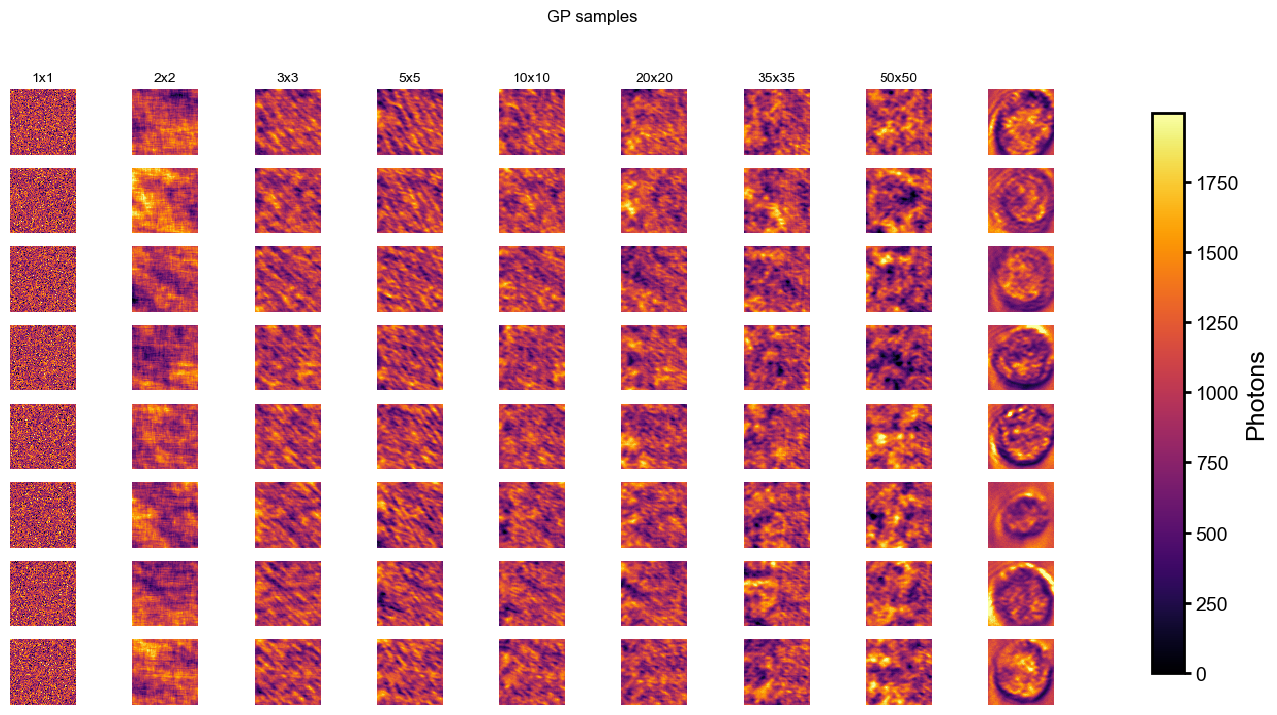

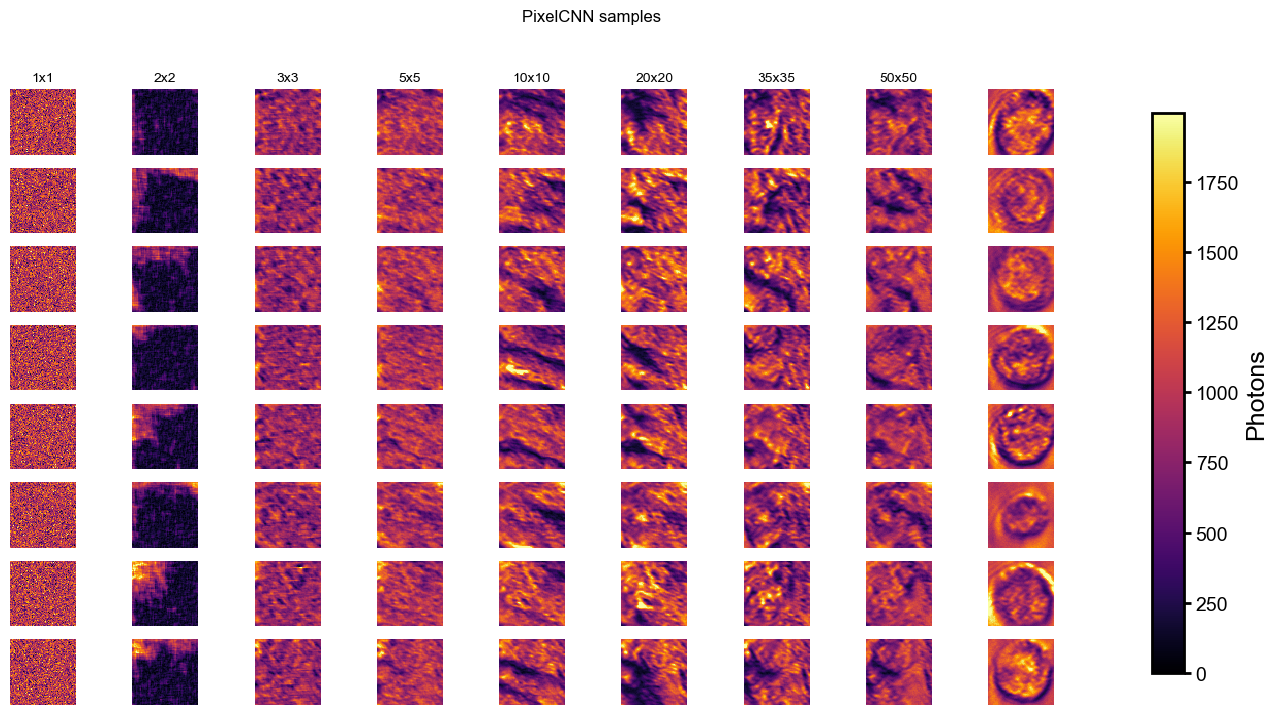

In [4]:
vmin, vmax = None, None

for model_name in ['GP', 'PixelCNN']:
    fig, axs = plt.subplots(num_samples, len(patch_sizes) + 1, figsize=( len(patch_sizes) * 2, num_samples ), sharex=True, sharey=True)
    for j, patch_size in enumerate(patch_sizes):
        model_samples_for_patch_size = samples[patch_sizes[j]][model_name]
        if vmin is None:
            vmin, vmax = np.percentile(model_samples_for_patch_size, .1), np.percentile(model_samples_for_patch_size, 99.9)
        for i in range(num_samples):
            im = axs[i, j].imshow(model_samples_for_patch_size[i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
            axs[i, j].axis('off')

    # show ground truth patch
    display_patches = extract_patches(images, sample_size, num_patches=num_samples, seed=7)
    for i in range(num_samples):
        axs[i, -1].imshow(display_patches[i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
        axs[i, -1].axis('off')

    # add colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_ylabel('Photons')

    # add a label to each col
    for j, patch_size in enumerate(patch_sizes):
        axs[0, j].set_title(f'{patch_size}x{patch_size}', fontsize=10)
    fig.suptitle(f'{model_name} samples', fontsize=12)

    fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + f'{model_name}_samples_vs_patch_size' + '.pdf', transparent=True)

/tmp/ipykernel_14594/1122547295.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=[''] + [f'{ps}x{ps}' for ps in np.arange(10, 51, 10)], xticks=np.arange(0, 51, 10))


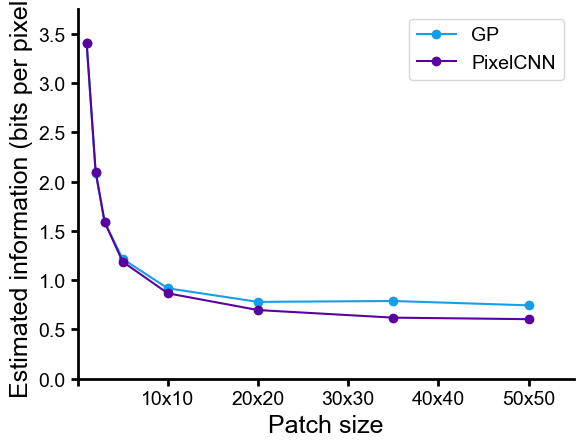

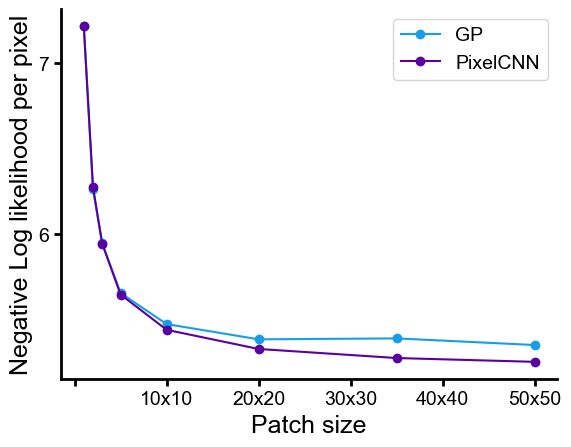

In [5]:
from matplotlib.ticker import MaxNLocator

# Mutual information vs patch size
fig, ax = plt.subplots()
ax.plot(patch_sizes, [mi_estimates_gp[ps] for ps in patch_sizes], 'o-', label='GP')
ax.plot(patch_sizes, [mi_estimates_pixel_cnn[ps] for ps in patch_sizes], 'o-', label='PixelCNN')
clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Estimated information (bits per pixel)', ylim=[0, 1.1 * 
                        max(max(mi_estimates_gp.values()), max(mi_estimates_pixel_cnn.values()))  ],
        xlim=[0, 1.1 * max(patch_sizes)], xticks=np.arange(0, 51, 10))
ax.set(xticklabels=[''] +[f'{ps}x{ps}' for ps in np.arange(10, 51, 10)])
ax.legend()

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + f'mi_vs_patch_size' + '.pdf', transparent=True)



fig, ax = plt.subplots()
nll_per_pixel_gp = [test_set_NLL_gp[ps] for ps in patch_sizes]
nll_per_pixel_pixel_cnn = [test_set_NLL_pixel_cnn[ps] for ps in patch_sizes]

ax.plot(patch_sizes, nll_per_pixel_gp, 'o-', label='GP')
ax.plot(patch_sizes, nll_per_pixel_pixel_cnn, 'o-', label='PixelCNN')

clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Negative Log likelihood per pixel')
ax.set(xticklabels=[''] + [f'{ps}x{ps}' for ps in np.arange(10, 51, 10)], xticks=np.arange(0, 51, 10))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + f'nll_vs_patch_size' + '.pdf', transparent=True)
